# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 9.1: basic shapes
- Exercise 9.2: working with Geopandas and interpolation
- Exercise 9.3: interactive plotting with folium

We begin with loading the standard packages:


In [4]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

## Exercises

### Part 9.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 9.1.1** Make a polygon which is square that has left,lower corner in 2,2 and right,upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `Multipolygon`

In [5]:
from shapely.geometry import Polygon

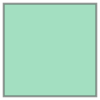

In [6]:
# [Your answer here]
square = Polygon([(2,2),(2,5),(5,5),(5,2)]) #bottom left, upper left, upper right, lower right corner
square

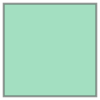

In [7]:
square_big = Polygon([(1,1),(1,10),(10,10),(10,1)]) # simply playing around with dimensions and depiction of figure/here not adjusted for size apparently
square_big

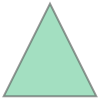

In [8]:
triangle = Polygon([(0,0),(4,0),(2,4)])
triangle

> **Ex. 6.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

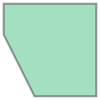

In [9]:
# [Your answer here]
square.difference(triangle)


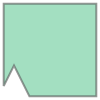

In [10]:
 square_big.difference(triangle) # just to understand coordinate measures and how/whether they respond to size


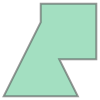

In [11]:
square.union(triangle)

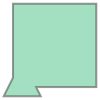

In [12]:
square_big.union(triangle) #just to see whether changes in side lengths are accomodated for: yes

> **Ex. 6.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

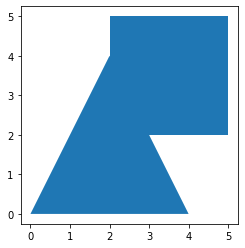

In [13]:
# [Your answer here] 
gpd.GeoSeries([square,triangle]).plot()


### Part 9.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 9.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands). you can use the `unary_union` method for GeoSeries.

In [14]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"

In [15]:
# [Your answer here]
kommuner = gpd.read_file(url)

In [16]:
kommuner.to_crs({'init':'epsg:25832'},inplace=True) #works

(419120.45001907204, 915342.5495994855, 6032160.249990183, 6419838.749997306)

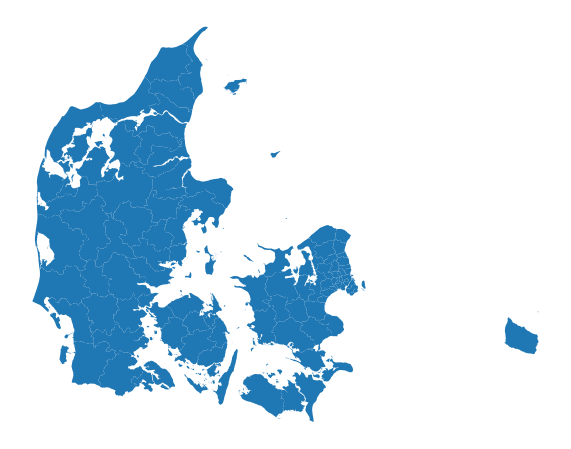

In [17]:
import matplotlib.pyplot as plt
kommuner.plot(figsize=(14,8))
plt.axis('off')

In [18]:
#join disjoint municipalities such as islands
sizes = kommuner.groupby('KOMNAVN').geometry.apply(lambda d: d.unary_union.area)

In [19]:
sizes.nlargest(3) #3 largest municipalities

KOMNAVN
Ringkøbing-Skjern    1.494151e+09
Viborg               1.419631e+09
Herning              1.323127e+09
Name: geometry, dtype: float64

Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [20]:
kommuner.columns = kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

> **Ex. 9.2.2** Make two boolean series as follows. 
> - first: row is True if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - second: row is True if the  the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [21]:
# [Your answer here]
#what municpalities are in ("is in"-> isin) sealand?
kommuner['sealand']=kommuner['regionsnavn'].isin(['Region Hovedstaden','Region Sjælland'])
#get rid of Bornholm
kommuner['not_bornholm']=~kommuner['komnavn'].isin(['Bornholm','Christiansø'])
##with the established boolean columns with regard to our criteria, we can no filter the data set to only include sealand
sealand = kommuner[kommuner.sealand&kommuner.not_bornholm]

> **Ex. 9.2.3** Explain what is the CRS of the GeoDataFrame. How is distance measured using this coordinate system. Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

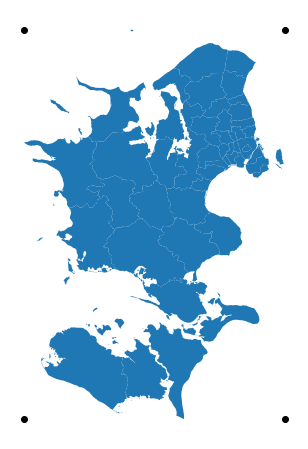

In [22]:
# [Your answer here]
# CRS of the geodataframe is metric, measures in meters, able to use Pythagoras and Euclidean distance
# Distance is measured in the geo data frame in meters --> metric

minx,miny,_,_=sealand.bounds.min(axis=0)
_,_,maxx,maxy=sealand.bounds.max(axis=0)

sealand.plot(figsize=(14,8))
plt.axis('off')
boundary = np.array([ #putting the bounds coordinates in list
    [minx, miny],
    [minx, maxy],
    [maxx, maxy],
    [maxx, miny]
])
x, y = boundary.T #assigning lists of coordinates to x and y
plt.scatter(x,y,c='black')



#### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 9.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

In [23]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf


/Users/qbj218/opt/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:25832'} != {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32})
  "(%s != %s)" % (left_df.crs, right_df.crs)


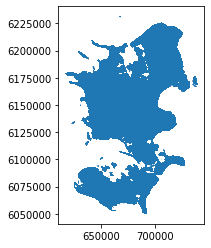

In [43]:
# [Your answer here]
#Make a grid of points 500m apart 

#constructs coordinates/points in grid: 
#numpy arange(starting value, end value, but open interval: 
#open interval makes perfect sense, since the maxx point 
#is not supposed to be the bottom left corner of another square in the grid.
#and increment: here 500m)
df_square = [(x,y) for x in np.arange(minx,maxx,500) 
             for y in np.arange(miny,maxy,500)]

# make coordinates into DataFrame for subsequent function and specify colum names
df_square = pd.DataFrame(data=df_square,columns=['e','n'])

#grid to be fed into function: square_df
#For each of these points construct a square polygon assuming
#that the point is the south west corner of the square. 
#Do this using cell_coords_to_polygons.
square_gdf = cell_coords_to_polygons(df_square)

#Use gpd.sjoin (=spatial join)to take the intersection of the municipalities 
#in sealand and the square grid you have constructed. 
#Plot the resulting geodataframe.
square_gdf = gpd.sjoin(sealand, square_gdf) #join house locations and municipalities

square_gdf.plot()

> **Ex. 9.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

In [96]:
from sklearn.neighbors import KNeighborsRegressor
KN = KNeighborsRegressor()

price_gdf = gpd.read_file('houseprices.GeoJSON')


In [58]:
price_file_check = pd.read_csv('house_prices.csv')
#see what data looks like

#price_gdf.head
#price_file_check.head



In [129]:
# [Your answer here]

#loop:

# for each year in sale_year column
for year in price_gdf['sale_year'].unique():
    
    subset_1 = price_gdf.loc[price_gdf['sale_year']==year]
    
    # extract houses sold between 1000 and 120000 Danish crowns, column price_area
    subset_2 = subset_1[(subset_1.price_area >999) & (subset_1.price_area <120001)]
    
    # select 4 columns to keep: sale_year, e, n,price_area
    regression_df=subset_2[['sale_year','e','n','price_area']]
    
    # drop rows with NAs
    regression_df = regression_df.dropna(axis='rows')
    
    # fit KneighborsRegressor: 

    # compute predictions
    # features: e and n, labels: price_area   
    X = regression_df[['e','n']]
    y = regression_df['price_area']

    KN.fit(X,y)

    # add 250 to each e and n coordinate to have midpoint coords
    # I guess this can be done quicker without assign, but didnt work immediately, soo..
    mid_square_gdf = square_gdf.assign(mid_e = square_gdf['e']+250) 
    mid_square_gdf = mid_square_gdf.assign(mid_n = mid_square_gdf['n']+250) 

    # compute predictions preds  with e and n from grid
    preds = KN.predict(mid_square_gdf[['mid_e','mid_n']])
    
    # add a column to grid dataframe square_gdf named p_{year} containing np.log20(preds)
    mid_square_gdf[f'p_{year}'] = np.log10(preds)



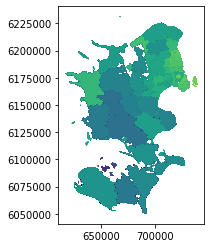

In [139]:
mid_square_gdf.drop(columns='e')
mid_square_gdf.drop(columns='n')


# Plot grid data 2012 
#mid_square_gdf.plot(column='p_2012')   
# does not seem to work :( maybe there is a bug in my loop and it didnt collect 2012 ..)
mid_square_gdf.plot(column='p_2013')   
